In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [0]:
n_epochs = 5
batch_size_train = 64
batch_size_test = 100
learning_rate = 0.01
momentum = 0.5
log_interval = 100

random_seed = 1
torch.manual_seed(random_seed)

# check if CUDA is available
device = torch.device("cpu")
if torch.cuda.is_available():
    print('CUDA is available!  Training on GPU ...')
    device = torch.device("cuda")
else:
    print('CUDA is not available.  Training on CPU ...')

CUDA is available!  Training on GPU ...


In [0]:
#  torchvision.transforms.Normalize(
#    (0.1307,), (0.3081,))

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
    batch_size=batch_size_train, shuffle=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/data/', train=False, download=True,
                         transform=torchvision.transforms.Compose([
                           torchvision.transforms.ToTensor()
                         ])),
    batch_size=batch_size_test, shuffle=True, pin_memory=True)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dens1 = nn.Linear(784, 256)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.2)
        self.dens2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(0.2)
        self.dens3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.2)
        self.dens4 = nn.Linear(64, 20)
        self.relu4 = nn.ReLU()
        self.drop4 = nn.Dropout(0.2)
        self.dens5 = nn.Linear(20, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.dens1(x)
        x = self.relu1(x)
        x = self.drop1(x)
        x = self.dens2(x)
        x = self.relu2(x)
        x = self.drop2(x)
        x = self.dens3(x)
        x = self.relu3(x)
        x = self.drop3(x)
        x = self.dens4(x)
        x = self.relu4(x)
        x = self.drop4(x)
        x = self.dens5(x)
        return F.log_softmax(x, dim=1)
    
    def extract_outputs(self, x, layer, neuron=None):
        outputs = []
        
        def hook(module, input, output):
            outputs.append(output)    
            
        for name, module in self.named_children():
            if name == layer:
                handle = module.register_forward_hook(hook)   
                
        out = self(x)
        
        if not neuron is None:
            outputs[0] = outputs[0][0][neuron]
   
        handle.remove()
  
        return outputs
  
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        # calculate robust loss
        loss = F.cross_entropy(model(data), target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [0]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [0]:
for epoch in range(1, n_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302933
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.300855
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.309253
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.309311
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.300814
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.287257
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.299283
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.286950
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.282867
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.275136

Test set: Average loss: 2.2600, Accuracy: 1820/10000 (18%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.277891
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.238356
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.216121
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.168850
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.978635
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.752849
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.572883
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.390635
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.215070
T

# Attack Time

In [0]:
targeted=True
confidence=0.0
c_range=(1e-3, 1e10)
search_steps=5
max_steps=1000
abort_early=True
box=(-1., 1.)
optimizer_lr=1e-2

log_frequency = 100

In [0]:
def atanh(x, eps=1e-2):
    """
    The inverse hyperbolic tangent function, missing in pytorch.

    :param x: a tensor or a Variable
    :param eps: used to enhance numeric stability
    :return: :math:`\\tanh^{-1}{x}`, of the same type as ``x``
    """
    x = x * (1 - eps)
    return 0.5 * torch.log((1.0 + x) / (1.0 - x))

def to_tanh_space(x, box=box):
    """
    Convert a batch of tensors to tanh-space. This method complements the
    implementation of the change-of-variable trick in terms of tanh.

    :param x: the batch of tensors, of dimension [B x C x H x W]
    :param box: a tuple of lower bound and upper bound of the box constraint
    :return: the batch of tensors in tanh-space, of the same dimension;
             the returned tensor is on the same device as ``x``
    """
    _box_mul = (box[1] - box[0]) * 0.5
    _box_plus = (box[1] + box[0]) * 0.5
    return atanh((x - _box_plus) / _box_mul)

def from_tanh_space(x, box=box):
    """
    Convert a batch of tensors from tanh-space to oridinary image space.
    This method complements the implementation of the change-of-variable trick
    in terms of tanh.

    :param x: the batch of tensors, of dimension [B x C x H x W]
    :param box: a tuple of lower bound and upper bound of the box constraint
    :return: the batch of tensors in ordinary image space, of the same
             dimension; the returned tensor is on the same device as ``x``
    """
    _box_mul = (box[1] - box[0]) * 0.5
    _box_plus = (box[1] + box[0]) * 0.5
    return torch.tanh(x) * _box_mul + _box_plus
  
def compensate_confidence(outputs, targets):
    """
    Compensate for ``self.confidence`` and returns a new weighted sum
    vector.

    :param outputs: the weighted sum right before the last layer softmax
           normalization, of dimension [B x M]
    :type outputs: np.ndarray
    :param targets: either the attack targets or the real image labels,
           depending on whether or not ``self.targeted``, of dimension [B]
    :type targets: np.ndarray
    :return: the compensated weighted sum of dimension [B x M]
    :rtype: np.ndarray
    """
    outputs_comp = outputs.clone()
    rng = torch.range(start=0, end=targets.shape[0]-1, dtype=torch.long, device=device)
    # targets = targets.int()
    if targeted:
        # for each image $i$:
        # if targeted, `outputs[i, target_onehot]` should be larger than
        # `max(outputs[i, ~target_onehot])` by `self.confidence`
        outputs_comp[rng, targets] -= confidence
    else:
        # for each image $i$:
        # if not targeted, `max(outputs[i, ~target_onehot]` should be larger
        # than `outputs[i, target_onehot]` (the ground truth image labels)
        # by `self.confidence`
        outputs_comp[rng, targets] += confidence
    return outputs_comp
  
def attack_successful(prediction, target):
    """
    See whether the underlying attack is successful.

    :param prediction: the prediction of the model on an input
    :type prediction: int
    :param target: either the attack target or the ground-truth image label
    :type target: int
    :return: ``True`` if the attack is successful
    :rtype: bool
    """
    if targeted:
        return prediction == target
    else:
        return prediction != target

In [0]:
inputs, targets = next(iter(test_loader))

inputs = inputs.to(device)
targets = targets.to(device)

In [0]:
batch_size = inputs.size(0)
num_classes = model(torch.tensor(inputs[0], requires_grad=False)).size(1)

# `lower_bounds`, `upper_bounds` and `scale_consts` are used
# for binary search of each `scale_const` in the batch. The element-wise
# inquality holds: lower_bounds < scale_consts <= upper_bounds
lower_bounds = torch.tensor(np.zeros(batch_size), dtype=torch.float, device=device)
upper_bounds = torch.tensor(np.ones(batch_size) * c_range[1], dtype=torch.float, device=device)
scale_consts = torch.tensor(np.ones(batch_size) * c_range[0], dtype=torch.float, device=device)

# Optimal attack to be found.
# The three "placeholders" are defined as:
# - `o_best_l2`          : the least L2 norms
# - `o_best_l2_ppred`    : the perturbed predictions made by the adversarial perturbations with the least L2 norms
# - `o_best_adversaries` : the underlying adversarial example of `o_best_l2_ppred`
o_best_l2 = torch.tensor(np.ones(batch_size) * np.inf, dtype=torch.float, device=device)
o_best_l2_ppred = torch.tensor(-np.ones(batch_size), dtype=torch.float, device=device)
o_best_adversaries = inputs.clone()

# convert `inputs` to tanh-space
inputs_tanh = to_tanh_space(inputs)
targets_oh = F.one_hot(targets).float()

# the perturbation tensor (only one we need to track gradients on)
pert_tanh = torch.zeros(inputs.size(), device=device, requires_grad=True)

optimizer = optim.Adam([pert_tanh], lr=optimizer_lr)

for const_step in range(search_steps):
  
    print('Step', const_step)
    
    # the minimum L2 norms of perturbations found during optimization
    best_l2 = torch.tensor(np.ones(batch_size) * np.inf, dtype=torch.float, device=device)
    
    # the perturbed predictions made by the adversarial perturbations with the least L2 norms
    best_l2_ppred = torch.tensor(-np.ones(batch_size), dtype=torch.float, device=device)
    
    # previous (summed) batch loss, to be used in early stopping policy
    prev_batch_loss = torch.tensor(np.inf, device=device)
    ae_tol = torch.tensor(1e-4, device=device)
    
    # optimization steps
    for optim_step in range(max_steps):
        
        adversaries = from_tanh_space(inputs_tanh + pert_tanh)
        pert_outputs = model(adversaries)

        # Calculate L2 norm between adversaries and original inputs
        pert_norms = torch.pow(adversaries - inputs, exponent=2)
        pert_norms = torch.sum(pert_norms.view(pert_norms.size(0), -1), 1)

        target_activ = torch.sum(targets_oh * pert_outputs, 1)
        maxother_activ = torch.max(((1 - targets_oh) * pert_outputs - targets_oh * 1e4), 1)[0]

        if targeted:           
            # if targeted, optimize to make `target_activ` larger than `maxother_activ` by `confidence`
            f = torch.clamp(maxother_activ - target_activ + confidence, min=0.0)
        else:
            # if not targeted, optimize to make `maxother_activ` larger than `target_activ` (the ground truth image labels) by `confidence`
            f = torch.clamp(target_activ - maxother_activ + confidence, min=0.0)

        # the total loss of current batch, should be of dimension [1]
        batch_loss = torch.sum(pert_norms + scale_consts * f)

        # Do optimization for one step
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        # "returns" batch_loss, pert_norms, pert_outputs, adversaries

        if optim_step % log_frequency == 0: print('batch [{}] loss: {}'.format(optim_step, batch_loss))

        if abort_early and not optim_step % (max_steps // 10):
            
            if batch_loss > prev_batch_loss * (1 - ae_tol):
                break
            prev_batch_loss = batch_loss

        # update best attack found during optimization
        pert_predictions = torch.argmax(pert_outputs, dim=1)
        comp_pert_predictions = torch.argmax(compensate_confidence(pert_outputs, targets), dim=1)
        for i in range(batch_size):
            l2 = pert_norms[i]
            cppred = comp_pert_predictions[i]
            ppred = pert_predictions[i]
            tlabel = targets[i]
            ax = adversaries[i]
            if attack_successful(cppred, tlabel):
                assert cppred == ppred
                if l2 < best_l2[i]:
                    best_l2[i] = l2
                    best_l2_ppred[i] = ppred
                if l2 < o_best_l2[i]:
                    o_best_l2[i] = l2
                    o_best_l2_ppred[i] = ppred
                    o_best_adversaries[i] = ax
                    
    # binary search of `scale_const`
    for i in range(batch_size):
        tlabel = targets[i]
        if best_l2_ppred[i] != -1:
            # successful: attempt to lower `scale_const` by halving it
            if scale_consts[i] < upper_bounds[i]:
                upper_bounds[i] = scale_consts[i]
            # `upper_bounds[i] == c_range[1]` implies no solution
            # found, i.e. upper_bounds[i] has never been updated by
            # scale_consts[i] until `scale_consts[i] > 0.1 * c_range[1]`
            if upper_bounds[i] < c_range[1] * 0.1:
                scale_consts[i] = (lower_bounds[i] + upper_bounds[i]) / 2
        else:
            # failure: multiply `scale_const` by ten if no solution
            # found; otherwise do binary search
            if scale_consts[i] > lower_bounds[i]:
                lower_bounds[i] = scale_consts[i]
            if upper_bounds[i] < c_range[1] * 0.1:
                scale_consts[i] = (lower_bounds[i] + upper_bounds[i]) / 2
            else:
                scale_consts[i] *= 10

Step 0
batch [0] loss: 0.9280296564102173
batch [100] loss: 0.018136832863092422
batch [200] loss: 0.014460964128375053
batch [300] loss: 0.013831041753292084
batch [400] loss: 0.013599553145468235
batch [500] loss: 0.013476535677909851
batch [600] loss: 0.013400744646787643
batch [700] loss: 0.013350140303373337
batch [800] loss: 0.013314418494701385
batch [900] loss: 0.013288169167935848
Step 1
batch [0] loss: 0.12307195365428925
batch [100] loss: 0.12085845321416855
batch [200] loss: 0.12082726508378983
batch [300] loss: 0.12097981572151184
Step 2
batch [0] loss: 1.1789371967315674
batch [100] loss: 0.9674735069274902
batch [200] loss: 0.9636998176574707
batch [300] loss: 0.9595181941986084
batch [400] loss: 0.9552007913589478
batch [500] loss: 0.9665858745574951
Step 3
batch [0] loss: 7.730571269989014
batch [100] loss: 2.361110210418701
batch [200] loss: 2.3970932960510254
Step 4
batch [0] loss: 2.330204486846924
batch [100] loss: 2.004525661468506
batch [200] loss: 2.016444683074

Perturbed Accuracy: 100/100 (100%)

Original Accuracy: 95/100 (95%)



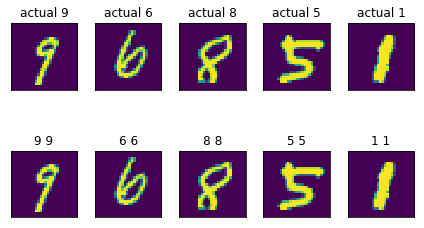

In [0]:
pert_output = model(o_best_adversaries)
orig_output = model(inputs)

pert_pred = torch.argmax(pert_output, dim=1)
orig_pred = torch.argmax(orig_output, dim=1)

pert_correct = pert_pred.eq(targets.data).sum()
orig_correct = orig_pred.eq(targets.data).sum()

pert_acc = 100. * pert_correct / len(targets)
orig_acc = 100. * orig_correct / len(targets)

print('Perturbed Accuracy: {}/{} ({:.0f}%)\n'.format(pert_correct, len(targets), pert_acc))
print('Original Accuracy: {}/{} ({:.0f}%)\n'.format(orig_correct, len(targets), orig_acc))

adversarial_examples = o_best_adversaries.cpu().detach().numpy()
input_examples = inputs.cpu().detach().numpy()

# inputs, adversarial_examples, targets
num_samples = 5

for i in range(1,num_samples+1):
    
    plt.subplot(2, num_samples, i)
    plt.imshow(np.squeeze(input_examples[i]))  
    plt.title('actual {}'.format(targets[i].item()))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(2, num_samples, num_samples+i)
    plt.imshow(np.squeeze(adversarial_examples[i]))
    plt.title('{} {}'.format(pert_pred[i].item(), orig_pred[i].item()))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()
plt.show()

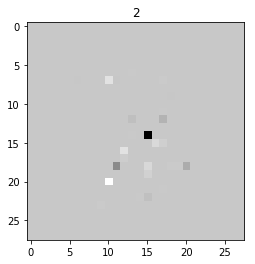

In [0]:
plt.imshow((o_best_adversaries[0] - inputs[0]).cpu().detach().numpy().reshape(28,28), cmap='gray') 
plt.title(targets[0].cpu().numpy())
plt.show()

In [0]:
# original
correct = 0

output = model(inputs)
pred = output.data.max(1, keepdim=True)[1]
correct += pred.eq(targets.data.view_as(pred)).sum()

acc = 100. * correct / len(targets)

print('\nAccuracy: {}/{} ({:.0f}%)\n'.format(correct, len(targets), acc))

# adversaries
correct = 0

output = model(o_best_adversaries)
pred = output.data.max(1, keepdim=True)[1]
correct += pred.eq(targets.data.view_as(pred)).sum()

acc = 100. * correct / len(targets)

print('\nAccuracy: {}/{} ({:.0f}%)\n'.format(correct, len(targets), acc))


Accuracy: 95/100 (95%)


Accuracy: 100/100 (100%)

